In [1]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from copy import copy
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn_extra.cluster import KMedoids

from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods,\
                             clustering,\
                             plot_clustering_scatter

from utils import entropy
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")
%autoreload 2

# see paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5

PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0

DATA_PRESERVED_THRESHOLD = 0.9
N_CMAP = 256

# Load data

# Load synthetic data

In [2]:
CPT = 0.01
clustering_results_root = f'results/clustering_cpt-{CPT}_synthetic/'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

targets_orig = {}
for path in glob.glob('data/synthetic/*'):
    dataframe = pd.read_csv(path, index_col=0)
    label = path.split('/')[-1].split('.')[0]
    targets_orig[label] = dataframe['target'].values
    
data_orig = {}
for path in glob.glob('data_processed/synthetic/*'):
    dataframe = pd.read_csv(path, index_col=0)
    label = path.split('/')[-1].split('.')[0]
    data_orig[label] = dataframe.values

data_pca = {}
for path in tqdm(glob.glob('./results/pca/synthetic/*')):
    label = path.split('/')[-1]
    data_pca[label] = np.genfromtxt(path, delimiter = ';')
        
data_embeddings = defaultdict(dict)
embeddings_path = './results/embeddings_synthetic'
inliers_indexes_all = {}
for emb_path in glob.glob(embeddings_path + '/*'):
    label_info = emb_path.split('/')[-1].split('.')[0]
    dataset, tax, embedding_type = label_info.split('_')
    d = np.load(emb_path, allow_pickle=True).item()
    label = dataset + '_' + tax
    data_embeddings[embedding_type][label] = d['Z_']
    inliers_indexes_all[label_info] = d['inliers_indexes_mae']
    
distance_root = 'distances_processed_synth'
# only L1 and L2 distances are supported
distances_names = ['L1', 'L2']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.31it/s]


# Clustering: precomputed distances

In [3]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [5]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)

In [6]:
methods_dict_distances = {
                           'HDBSCAN':[HDBSCAN, 
                              {'min_cluster_size':[5,10,25,50], 
                               'min_samples':[None,5,10,15,20],
                               'metric':['precomputed'],
                               'core_dist_n_jobs':[1],
                               'random_state':[42]}
                               ],
                           'KMedoids':[KMedoids, 
                                       {'n_clusters':np.arange(2, 10, 1),
                                        'method':['pam'],
                                        'metric':['precomputed'],
                                        'init':['k-medoids++'],
                                        'random_state':[42]}],
                           'SpectralClustering':[SpectralClustering_prec, 
                                                 {'n_clusters':np.arange(2, 10, 1), 
                                                  'gamma':[1., 5, 10, 15],
                                                  'eigen_tol':[1e-4]}]
                        }

In [7]:
clustering_results_root

'results/clustering_cpt-0.01_synthetic/'

In [ ]:
for distance_name, distance_dict in tqdm(distances_orig.items()):
    
    results_path = os.path.join(clustering_results_root, f'{distance_name}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    
    distance_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(distance_dict),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict_distances,
                                                                                      precomputed=True,
                                                                                      d=data_orig[label].shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in distance_dict.items())

    # create compatible metrics dicts
    for i,label in enumerate(distance_dict.keys()):
        for j, method_name in enumerate(methods_dict_distances.keys()):
            distance_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, distance_cluster_results)
    
clear_output()

 50%|████████████████████████████████████████████████████████████████                                                                | 2/4 [55:42<56:11, 1685.51s/it]

# Clustering: PCA

In [9]:
methods_dict = {'HDBSCAN':[HDBSCAN, 
                          {'min_cluster_size':[5,10,25,50], 
                           'min_samples':[None,5,10,15,20],
                           'core_dist_n_jobs':[1]}],
               'KMedoids':[KMedoids, 
                           {'n_clusters':np.arange(2, 10, 1),
                            'method':['pam'],
                            'init':['k-medoids++'],
                            'random_state':[42]}],
               'SpectralClustering':[SpectralClustering, 
                                     {'n_clusters':np.arange(2, 10, 1), 
                                     'affinity':['nearest_neighbors'],
                                     'n_neighbors': [5, 15, 25, 50], 
                                     'eigen_tol':[1e-4],
                                     'random_state':[42]}]}

In [11]:
results_path = os.path.join(clustering_results_root, f'pca_cluster_results')

pca_cluster_results = defaultdict(dict)

clustering_data_results = Parallel(n_jobs=len(data_pca),
                                   mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                  methods_dict,
                                                                                  precomputed=False,
                                                                                  d=data.shape[1],
                                                                                  cluster_perc_threshold=CPT)
                                                        for label, data in data_pca.items())

# create compatible metrics dicts
for i,label in enumerate(data_pca.keys()):
    for j, method_name in enumerate(methods_dict.keys()):
        pca_cluster_results[label][method_name] = clustering_data_results[i][method_name]

np.save(results_path, pca_cluster_results)

clear_output()

# Clustering: embeddings 

In [12]:
for embedding_type, embeddings in tqdm(data_embeddings.items()):
    
    results_path = os.path.join(clustering_results_root, f'{embedding_type}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    else:
        print(f'{results_path} exists, calculating...')
    
    embeddings_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(embeddings),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict,
                                                                                      precomputed=False,
                                                                                      d=data.shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in embeddings.items())

    # create compatible metrics dicts
    for i,label in enumerate(embeddings.keys()):
        for j, method_name in enumerate(methods_dict.keys()):
            embeddings_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, embeddings_cluster_results)
    
clear_output()

# Synthetic data
uncomment all cells in this section to use code for figures generation

In [ ]:
# ['lle', 'L1', 'pca', ...]
representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

clustering_results_df = []

for representation in representations_names:
    
    clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cl_res_label in cluster_results.items():
        #results for each method given dataset
        for cl_method, cl_res_label_method in cl_res_label.items():
            
            if len(cl_res_label_method) == 0:
                print('Empty results for:', representation, label, cl_method)
                continue
                
            df = pd.DataFrame(cl_res_label_method)
            
            df['label'] = label
            df['representation'] = representation
            df['cl_method'] = cl_method
            # n_clusters found
            
            # real clusters
            y = targets_orig[label]
            n_clusters_real = len(np.unique(y))
            df['n_cl_real'] = n_clusters_real - 1 
            
            # calculate Adjusted Rand Index and number of clusters
            ari_s = []
            n_cl_s = []
            n_cl_real_s = []
            for cl_res_label_method_i in cl_res_label_method:
                y_ = cl_res_label_method_i['labels']
                mask = cl_res_label_method_i['mask']
                
                # if it is a clustering for manifold-learning embedding
                if representation in data_embeddings.keys():
                    inliers = inliers_indexes_all[label + '_' + representation]
                else:
                    inliers = np.arange(len(y))
                    
                n_cl  = len(np.unique(y_))
                n_cl_s.append(n_cl)
                
                ari = adjusted_rand_score(y[inliers][mask], y_) 
                ari_s.append(ari)
                
            df['ari'] = ari_s
            df['n_cl'] = n_cl_s
            
            clustering_results_df.append(df)
            
clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

In [24]:
clustering_results_df_ = clustering_results_df.dropna()
clustering_results_proper = clustering_results_df_.query('ari > 0.7 & (n_cl == n_cl_real)')
assert len(np.unique(clustering_results_proper['label'])) == 9 # all datasets were partitioned properly

In [25]:
len(clustering_results_proper.query(f'ps >= {PS_THRESHOLD} & dbcv > {DBCV_THRESHOLD}')['label'].unique())

9

In [26]:
len(clustering_results_proper.query(f'dbind <= {DBIND_THRESHOLD} & silh > {SILHOUETTE_THRESH}')['label'].unique())

9

In [27]:
clustering_results_df_ = clustering_results_df_.query('dbind < 3')

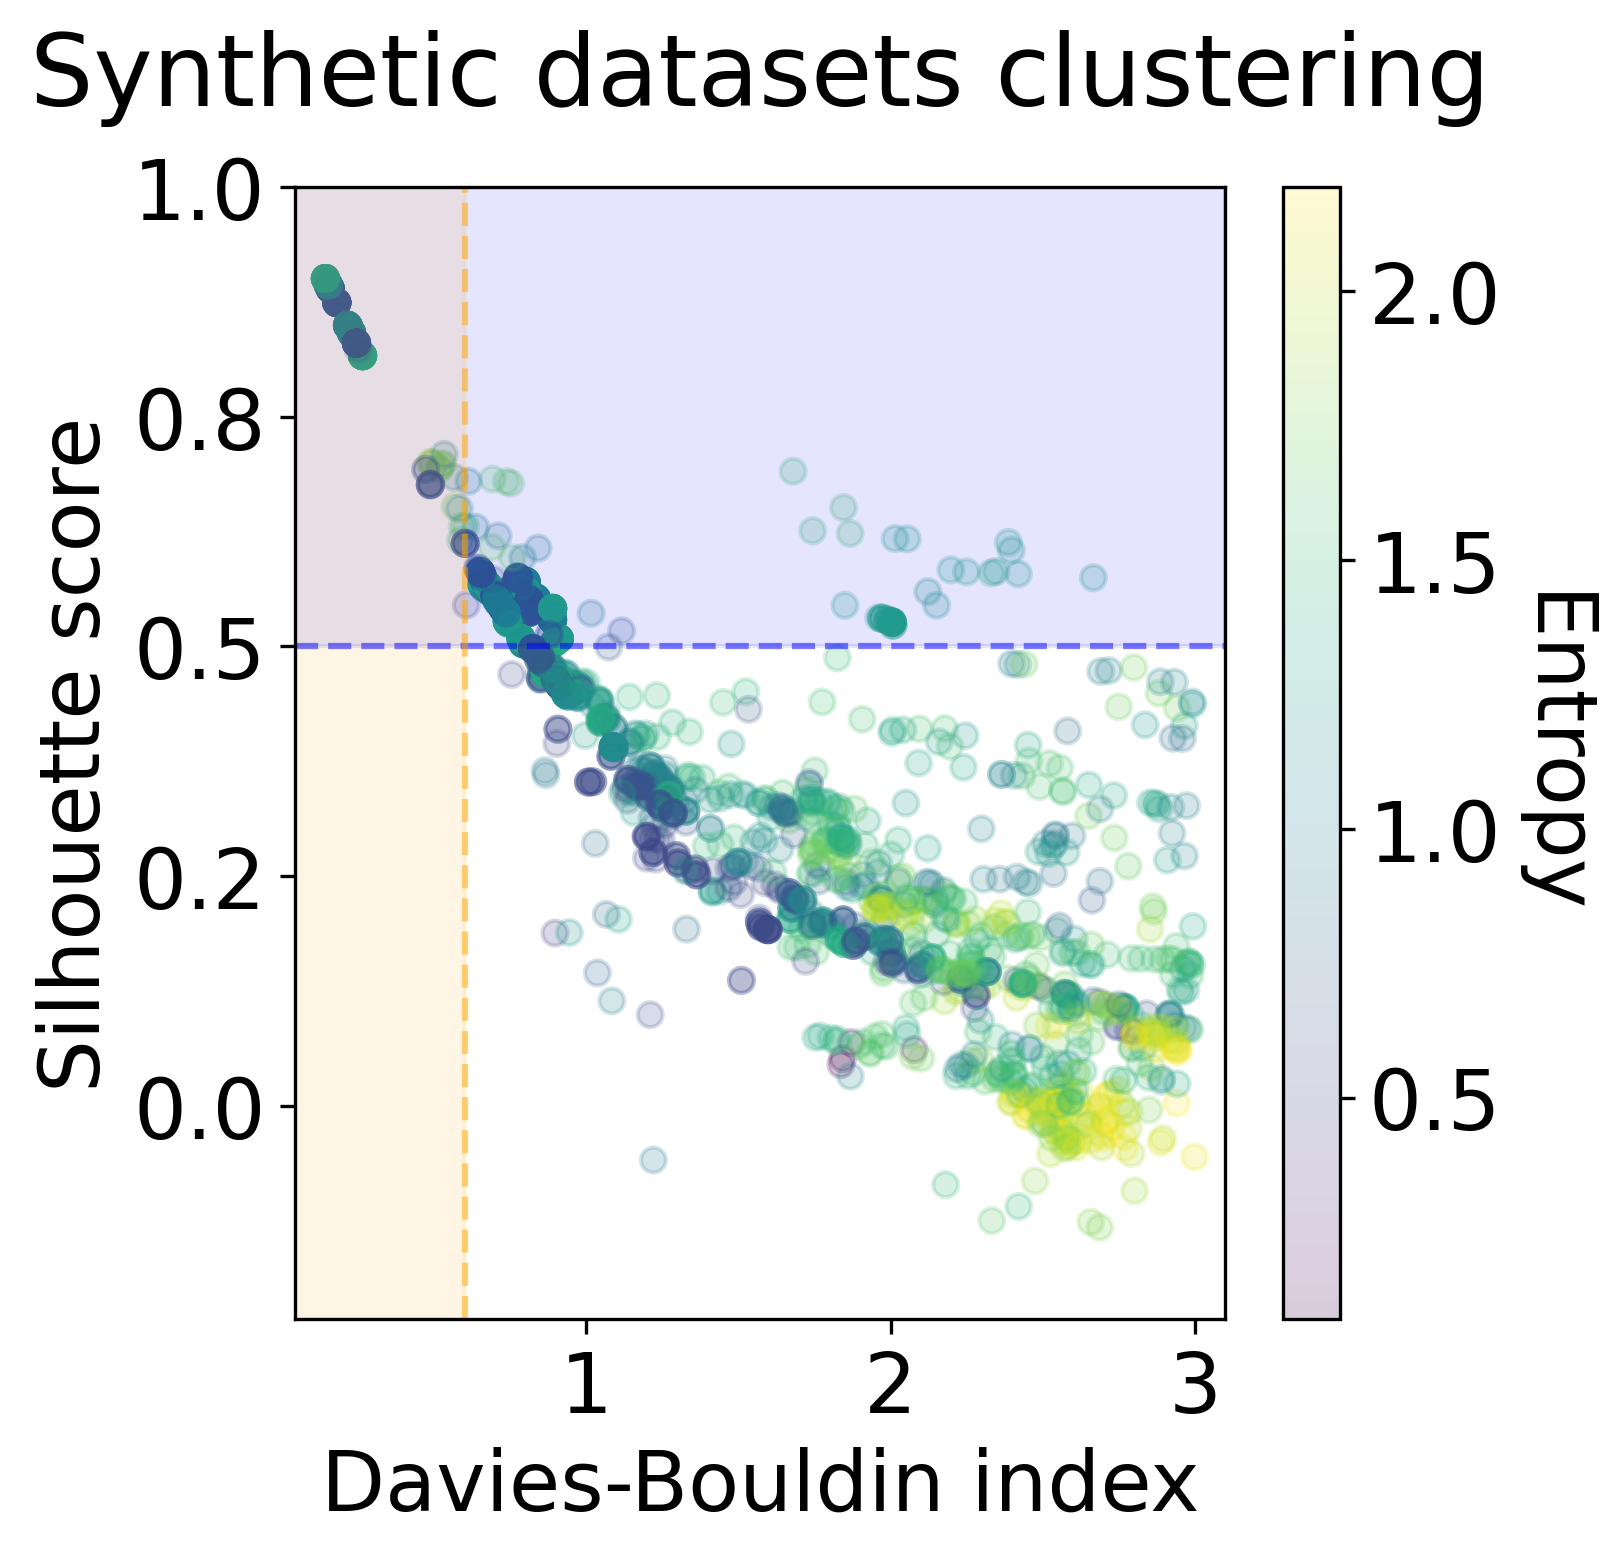

In [35]:
plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

nice_repr = {'tsne':'t-SNE',
             'umap':'UMAP',
             'spectral':'SE'}
nice_cl = {'SpectralClustering':'Spectral cl.',
           'HDBSCAN':'HDBSCAN'}

plot_clustering_scatter(clustering_results_df_, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Synthetic datasets clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [37]:
# ind = clustering_results_df_.query(f'silh >= {SILHOUETTE_THRESH} & dbind <= {DBIND_THRESHOLD} & ps > {PS_THRESHOLD}').groupby('label')['silh'].idxmax().values
# clustering_results_df_.loc[ind].query('n_cl_real == n_cl')

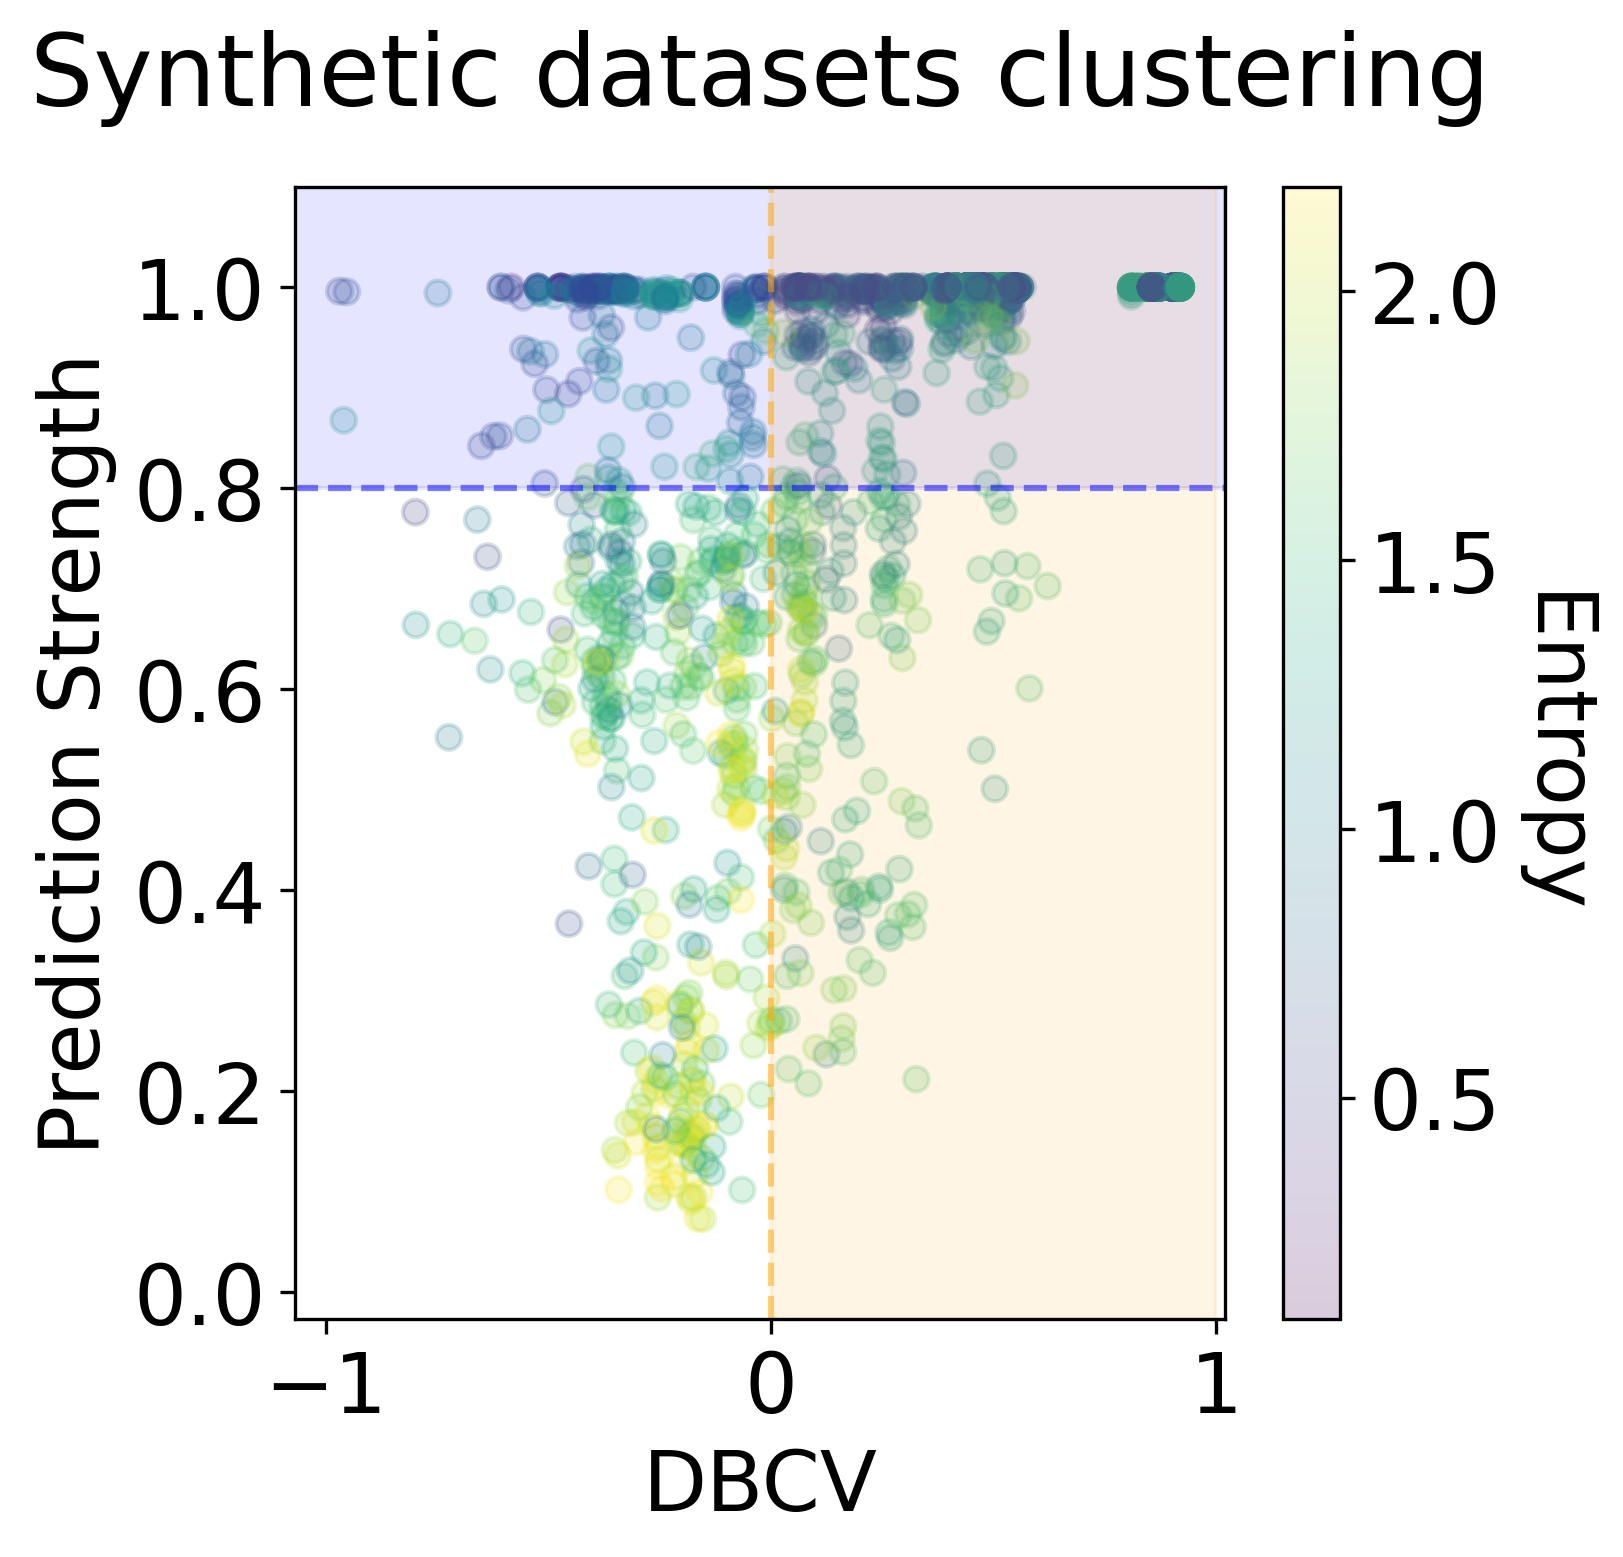

In [33]:
plot_clustering_scatter(clustering_results_df_, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Synthetic datasets clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [18]:
# ind = clustering_results_df_.query(f'dbcv >= {DBCV_THRESHOLD} & ps >= {PS_THRESHOLD} & data_used > {DATA_PRESERVED_THRESHOLD}').groupby('label')['dbcv'].idxmax().values
# clustering_results_df_.loc[ind].query('n_cl_real == n_cl')